<h2>"Protein Local Processing"</h2>
This is my (Elden) first attempt to seriously analyse the <em>local</em> structure around a protein of interest.</br>
</br>
I am writing this code starting with the protein (ID) YBR196C

In [1]:
"""Imports and arguments"""

import csv

import networkx as nx

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import network_utilities as nu
import random
import networkx.algorithms.community as nx_comm

# some basic settings for plotting figures
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 20}

plt.rc('font', **font)

# THE PROTEIN OF INTEREST ================================#
this_protein = 'YBR247C';                                 #
# ========================================================#

long_outputs = True;

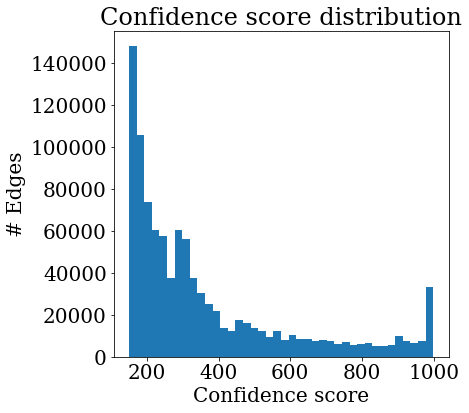

In [2]:
"""Loading data"""

# This is the variable that will store the protein names. 
ess_list = []; 

with open('essential_proteins.csv', newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])
    
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("./yeast_protein_edgelist_trimmed.txt",comments="#",nodetype=str)

# For interest, plot the distribution of confidence scores
if (long_outputs):
    plt.figure(figsize=(6,6));
    full_edges = G0.edges()
    these_weights = [G0[u][v]['weight'] for u,v in full_edges]

    plt.hist(these_weights, bins=40);
    plt.title("Confidence score distribution")
    plt.xlabel("Confidence score")
    plt.ylabel("# Edges")
    plt.show();
    
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700;
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);

In [3]:
"""Louvain communities"""

# Run the Louvain community finding algorithm on the giant subgraph
communities = nx_comm.louvain_communities(G)
print("We have found", len(communities), "communities")
for i in range(len(communities)):
    print(i,": has",len(communities[i]), "nodes");
    
# The community containing the protein of interest
protein_comm = {'',};

# Search for the community containing the protein of interest
for c in range(len(communities)):
    if (this_protein in communities[c]): 
        print(this_protein, "is in community c =", c)
        #print("which consists of:", communities[c])
        #print()
        protein_comm = communities[c];

We have found 13 communities
0 : has 554 nodes
1 : has 349 nodes
2 : has 903 nodes
3 : has 248 nodes
4 : has 177 nodes
5 : has 1003 nodes
6 : has 281 nodes
7 : has 94 nodes
8 : has 374 nodes
9 : has 1096 nodes
10 : has 289 nodes
11 : has 342 nodes
12 : has 222 nodes
YBR247C is in community c = 8


 
Local community of YBR247C
----------------------------------------------------------------------------------------------
The local community is a Graph with 374 nodes and 17533 edges
Protein  YBR247C is at index 254
Geodesic distances from YBR247C range from  0 to 5
The highest 5 subgraph central nodes are ['YPR010C', 'YPL029W', 'YPL266W', 'YPR110C', 'YPR190C']
The highest 5 degree nodes are ['YPR010C', 'YPL029W', 'YPL266W', 'YPR110C', 'YPR190C']


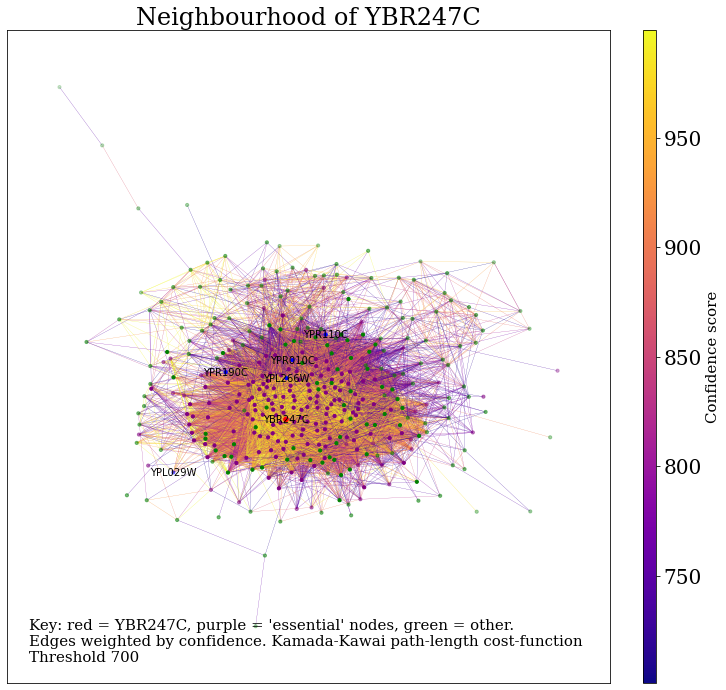

In [35]:
# Take the network of just the community of the protein of interest
protein_comm_network = nu.cutdown_network(G, protein_comm)



# ------------------------------------------------------------------------------------------------------------ #
# METRICS                                                                                                      #
# We define a few metrics on which to base coloring/design                                                     #
# ------------------------------------------------------------------------------------------------------------ #

# Index of the protein of interest
index_of_protein = list(protein_comm_network.nodes).index(this_protein);

# Geodesic distance from the protein of interest:
path_lens = [];
this_node_list = list(protein_comm_network.nodes);
for i in range(len(protein_comm_network.nodes)):
    path_len = nx.shortest_path_length(protein_comm_network, source=this_node_list[i], target=this_protein);
    path_lens.append(path_len);


# the first few subgraph-central nodes:
num_subgraph_central_nodes = 5;
subgraph_centrality_dict = nx.subgraph_centrality(protein_comm_network)
subgraph_central_nodes = sorted(subgraph_centrality_dict,key=lambda x: x[1], reverse=True)[:num_subgraph_central_nodes]

# the first few high degree nodes:
num_high_degree_nodes = 5;
degree_dict = {x[0]:x[1] for x in nx.degree(protein_comm_network)}
high_degree_nodes = sorted(degree_dict,key=lambda x: x[1], reverse=True)[:5]

# Text out:
print(" ")
print("==============================================================================================")
print("Local community of", this_protein)
print("----------------------------------------------------------------------------------------------")
print("The local community is a", protein_comm_network)
print('Protein ', this_protein, 'is at index', index_of_protein);
print("Geodesic distances from", this_protein, "range from ", min(path_lens), "to", max(path_lens))
print("The highest", num_subgraph_central_nodes, "subgraph central nodes are", subgraph_central_nodes)
print("The highest", num_high_degree_nodes, "degree nodes are", high_degree_nodes)
print("==============================================================================================")

# ------------------------------------------------------------------------------------------------------------ #
# DESIGN CONSTRUCTORS                                                                                          #
# We use the nu.value_lambda_result(...) function do create ordered lists of the coloring/design of nodes      #
# REMEMBER that only the result of the _first_ test to pass is displayed!                                      #
# ------------------------------------------------------------------------------------------------------------ #

my_colors = nu.value_lambda_result(
    list(protein_comm_network.nodes), # values
    [lambda p: p == this_protein, lambda p: p in subgraph_central_nodes, lambda p: p in ess_list], # tests
    ['red','blue','purple'], # results
    default = 'green');  

my_sizes = nu.value_lambda_result(
    list(protein_comm_network.nodes), # values
    [lambda p: p == this_protein, lambda p: p in ess_list], #
    [20,10], # results
    default = 10);  

my_alpha = nu.value_lambda_result(
    list(protein_comm_network.nodes), # values
    [lambda p: p != this_protein], # test
    [lambda p: 1/(nx.shortest_path_length(protein_comm_network, source=p, target=this_protein))], # results
    default = 1);  
# for some reason this is dividing by zero without the +0.1... shouldn't the lambda fix that?

my_labels = nu.value_lambda_result(
    list(protein_comm_network.nodes), # values
    [lambda p: p == this_protein or p in subgraph_central_nodes], # test
    [lambda p: p], # results
    default = "");



# Draw the network
nu.my_draw(protein_comm_network, kkl=True, node_color=my_colors, node_size=my_sizes, alpha=my_alpha, 
        key_text="Key: red = "+this_protein+", purple = 'essential' nodes, green = other. "+
        "\nEdges weighted by confidence. Kamada-Kawai path-length cost-function \nThreshold "+str(threshold_score), 
        title_text="Neighbourhood of "+this_protein, with_labels=True, labels=my_labels);

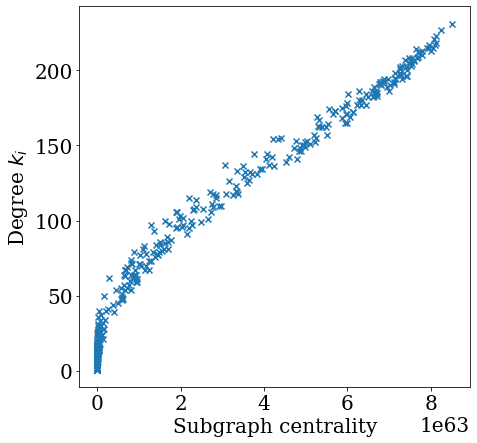

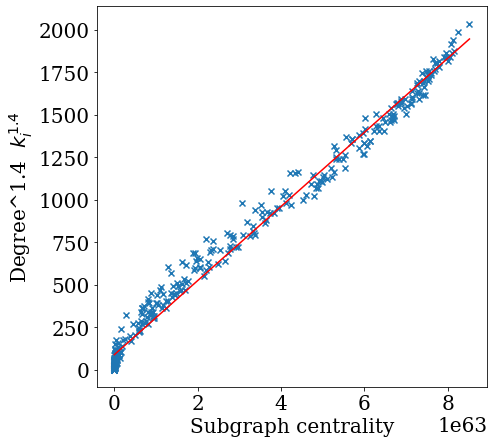

In [67]:
"""Some plots and structural analysis of this community"""

sg_central_vals = list(subgraph_centrality_dict.values())
degree_vals = list(degree_dict.values())

deg_power=1.4;
degree_vals_squ = [d**deg_power for d in degree_vals]

plt.figure(figsize=(7,7))
plt.scatter(sg_central_vals,degree_vals, marker="x")
plt.xlabel("Subgraph centrality")
plt.ylabel("Degree $k_i$")

plt.figure(figsize=(7,7))
plt.scatter(sg_central_vals,degree_vals_squ, marker="x")
plt.xlabel("Subgraph centrality")
plt.ylabel("Degree^"+str(deg_power)+"  $k_i^{"+str(deg_power)+"}$")
plt.plot(np.unique(sg_central_vals), 
         np.poly1d(np.polyfit(sg_central_vals, degree_vals_squ, 1))(np.unique(sg_central_vals)),color="r")